# **Lesson 2 - Measuring Mass in More Complex Mixtures**

In this lesson, we will delve deeper into proteomic mass spectrometry, focusing on the analysis of more complicated mixtures. **Lesson 1** had only one peptide, this lesson will have dozens.

## **Assumptions**

It is assumed that the reader has completed the prior lesson and is familiar with basics of biology and introductory chemistry. From the previous lesson, it is critical that you understand m/z and charge states and how they're related.

## **Goals**

At the end of this lesson, you should be able to:

- Understand the distinction between peptides and proteins and which is being measured in a proteomics experiment.
- Analyze a mass spectrum derived from a complex mixture of multiple peptides.
- Identify limitations associated with using m/z for peptide identification.

## **Context**

In [Lesson 1](https://colab.research.google.com/drive/1sDMcPdqfggWA1vrD4Odtruw_0owKnIMy#scrollTo=LIgA_z9ha0tP), we explored data from a single peptide, which manifested as two peaks in the mass spectrum due to the peptide adopting two charge states. Now, we'll shift our focus to a moderately complex mixture, potentially containing 50-100 distinct peptides.

## **Using this Tutorial**

This tutorial is designed to be interactive, and you are encouraged to change the code and explore. To do this, you'll need to save a copy of this so that you have editing permissions. Use `File->Save a copy in Drive` to make an editable copy for yourself. Colab notebooks consist of text cells (like this one) and code cells. You interact with the notebook by executing (running) the code cells by clicking the "play button" in each cell. You can also run all cells at once by using `Runtime->Run all`.

---

## **Part 1. Installation and Setup**

Before diving into the practical aspects of measuring mass in complex mixtures, let's prepare our environment by installing the necessary Python packages and defining the necessary functions. These packages will enable us to analyze and visualize the data effectively. To apply the concepts we've learned, we'll be working with real data, so we'll be loading the data files into the Colab environment using `gdown`.

In this notebook, some code cells have been 'hidden' for brevity, like the next few below. You can recognize these because they just have a play button and a small text prompt `Show code`. In addition to the setup code, these include several functions that we will use throughout the lesson - some functions from previous lessons and some plotting code. You may want to look at this later in the lesson, but for now you can probably just click through. The first task is to establish the basic ideas behind **digestion**.

In [ ]:
# @title Run this cell to set up the coding environment, including installing and loading necessary Python packages and loading in the data files.
%%capture
!pip install pyteomics
!pip install gdown
!pip install plotly

import pyteomics
from pyteomics import mzml, auxiliary
import gdown
import plotly.graph_objects as go


# Download the ms file
!gdown 1E_ipDFM1u6bIKXPYq-ZzZ8xP1Mj_tHyM
mzml_path = '/content/CA_DirectInfusion_FullSpectrum_400_1500.mzML'

# Download the whole human proteome file
!gdown 1uLk9X7mjOeEi03lXg_pFe869vKHwS6BI
human_proteome_path = '/content/Human_proteome.fasta'

In [ ]:
# @title Run this cell to create our amino acid dictionary (from Lesson 1).
aa_mass = {'A': 71.037114, 'R':156.101111 , 'N': 114.042927,
           'D': 115.026943, 'C': 103.009185, 'E': 129.042593,
           'Q' : 128.058578, 'G': 57.021464, 'H': 137.058912,
           'I': 113.084064, 'L': 113.084064, 'K': 128.094963,
           'M' : 131.040485, 'F':  147.068414, 'P':  97.052764,
           'S': 87.032028, 'T': 101.047679, 'U': 150.95363,
           'W': 186.079313, 'Y': 163.06332, 'V': 99.068414}

In [ ]:
# @title Run this cell to declare a function that calculates the neutral mass of a peptide (from Lesson 1).

def get_neutral_mass(peptide, aa_mass):
  neutral_mass = 0
  mass_Hydrogen = 1.0078
  mass_Oxygen = 15.994915

  neutral_mass = 0
  for aa in peptide:
    neutral_mass+=aa_mass[aa]
  neutral_mass += mass_Hydrogen #n-terminal hydrogen
  neutral_mass += (mass_Hydrogen + mass_Oxygen) #C-terminal OH
  return neutral_mass

In [ ]:
# @title Run this cell to declare a function that digests an amino acid sequence into peptides with Trypsin.
def cut_with_trypsin(protein_seq, aa_mass):
  peptide_dict = {}
  peptide = ''
  for aa in protein_seq:
    peptide += aa
    if (aa == 'R' or aa == 'K'): # trypsin cuts after 'R' and 'K'
      # the peptide finishes here. Get the neutral mass and then store in the dictionary
      peptide_dict[peptide] = get_neutral_mass(peptide, aa_mass)
      peptide = ''
  # returns a python dictionary with string : neutral_mass pairs
  return peptide_dict

In [ ]:
# @title Run this cell to declare a function that plots a mass spectrum (from Lesson 1).
def plot(spectrum, x_min = None, x_max = None, title = None):
    X = spectrum['m/z array']
    Y = spectrum['intensity array']
    Y_max = max(Y)
    Y_percentage = [(y/Y_max)*100 for y in Y]

    if not spectrum:
        x_min = spectrum['lowest observed m/z']
        x_max = spectrum['highest observed m/z']

    trace = go.Scatter(
        x = X,
        y = Y_percentage,
        mode = 'lines',
        name = 'Spectrum',
        line=dict(color='black')
    )

    layout = go.Layout(
        title = title,
        xaxis = dict(
            title = 'm/z',
            range = [x_min, x_max],
            linecolor='black',
            mirror=True
        ),
        yaxis = dict(
            title = 'Intensity (%)',
            range = [0, 105],
            linecolor='black',
            mirror=True
        ),
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

In [ ]:
# @title Run this cell to declare a function that calculates the m/z values for a peptide sequence at charge states 1, 2, and 3.

def get_mz_vals(peptide, aa_mass):
  mass_proton = 1.007276466879
  mz_list = []
  neutral_mass = get_neutral_mass(peptide, aa_mass)
  for charge in range(1, 4):
    mz = (neutral_mass + (mass_proton*charge))/ charge
    mz_list.append(mz)
  return mz_list

## **Part 2. Measuring Proteins**

Proteins come in all shapes and sizes which can give them very distinct chemical properties. [Histone H2B](https://en.wikipedia.org/wiki/Histone_H2B) is a short protein with 126 amino acids, while [Titin](https://en.wikipedia.org/wiki/Titin) is a giant with over 30,000 amino acids! Some proteins, like Histone H2B, have many basic amino acids and hold charge well, while others, like [Albumin](https://en.wikipedia.org/wiki/Albumin) don't. Some proteins, like the [Lysozyme](https://en.wikipedia.org/wiki/Lysozyme), are readily dissolved in water, while others, like the ones in our cell membranes, aren't.

Because proteins are so different, it can be hard for the mass spectrometer to measure them directly. To make our job easier, we often break the proteins down into smaller pieces, peptides.

To break a protein into smaller peptides, we use a process called [**digestion**](https://en.wikipedia.org/wiki/Proteolysis), which is when an enzyme cuts a protein up into peptides at specific amino acids. In this lesson, we will use an enzyme commonly used for digestion called **trypsin** to digest a protein called [Bovine Carbonic Anhydrase 2](https://www.uniprot.org/uniprotkb/P00921/entry) (CA). Although there is some debate as to the efficiency of trypsin ([Rodriguez et al.](https://pubs.acs.org/doi/10.1021/pr0705035)), for this lesson, we can assume that it will perfectly cut our protein (CA) after amino acids **Lysine (K)** and **Arginine (R)**. The first few peptides created by the digestion of CA are shown below.

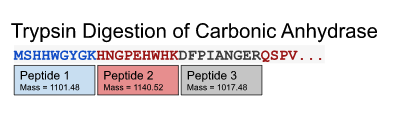

This graphic shows that after digestion, the protein Carbonic Anhydrase 2 (CA) has been cut into peptides. The first nine amino acids, `MSHHWGYGK`, form one peptide. This peptide has a calculated mass of 1101.48. The next nine amino acids, `HNGPEHWHK`, form a different peptide, with mass 1140.52. The rest of the protein keeps getting cut into peptides following the digestion rules outlined above.

In the code cells below, we digest CA into peptides *in silico* and store the information in a Python dictionary in the following format:

```
peptides = {
  peptide_seq_1: neutral_mass,
  peptide_seq_2: neutral_mass,
  ...
}
```

Run the code cells below to create the peptide dictionary.

In [ ]:
# protein sequence of carbonic anhydrase
CA_protein = 'MSHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKPLALVYGEATSRRMV\
NNGHSFNVEYDDSQDKAVLKDGPLTGTYRLVQFHFHWGSSDDQGSEHTVDRKKYAAELHL\
VHWNTKYGDFGTAAQQPDGLAVVGVFLKVGDANPALQKVLDALDSIKTKGKSTDFPNFDP\
GSLLPNVLDYWTYPGSLTTPPLLESVTWIVLKEPISVSSQQMLKFRTLNFNAEGEPELLM\
LANWRPAQPLKNRQVRGFPK'

In [ ]:
# CA digestion by trypsin

# This function is defined above in Part 1 - take a look at the code up
#   there to see what it is doing
CA_peptides = cut_with_trypsin(CA_protein, aa_mass)
print(CA_peptides)

{'MSHHWGYGK': 1101.4813760000002, 'HNGPEHWHK': 1140.521275, 'DFPIANGER': 1017.487909, 'QSPVDIDTK': 1001.502891, 'AVVQDPALK': 939.5388829999999, 'PLALVYGEATSR': 1275.6822440000003, 'R': 174.111626, 'MVNNGHSFNVEYDDSQDK': 2097.8697380000003, 'AVLK': 429.29507, 'DGPLTGTYR': 978.477003, 'LVQFHFHWGSSDDQGSEHTVDR': 2583.1526639999997, 'K': 146.105478, 'YAAELHLVHWNTK': 1580.8099040000002, 'YGDFGTAAQQPDGLAVVGVFLK': 2252.147679, 'VGDANPALQK': 1011.53486, 'VLDALDSIK': 972.5491119999999, 'TK': 247.15315700000002, 'GK': 203.126942, 'STDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLK': 4592.340620999999, 'EPISVSSQQMLK': 1345.691102, 'FR': 321.18004, 'TLNFNAEGEPELLMLANWR': 2217.0887889999995, 'PAQPLK': 652.390762, 'NR': 288.154553, 'QVR': 401.23861800000003, 'GFPK': 447.24812000000003}


Now that we have enumerated the peptides that we expect to see, let's look at the mass spectrum.

## **Part 3. Visualizing the Mass Spectrum**

One of the most important things to understand when looking at a mass spectrum is that not all peptides created through digestion are detected in the mass spectrum. This can be attributed to the ionization process, where some peptide sequences take a charge more easily than others. This also explains why not all peaks in the MS below are the same intensity.

As these lessons are designed for data scientists, we are going to skip over a lot of analytical chemistry here, but the important ideas are:
- Not all ions are observed.
- Not all ions are of equal intensity.

To begin, let's plot the spectrum we want to work with in this lesson. Run the code cells below to do this.

In [ ]:
# get our spectrum object
scan_num = 53
mzml = pyteomics.mzml.MzML(mzml_path)
my_id = 'controllerType=0 controllerNumber=1 scan='+ str(scan_num)

spectrum = mzml.get_by_id(my_id)

In [ ]:
# plot the spectrum

# This function is defined above in Part 1 - take a look at the code up
#   there to see what it is doing
plot(spectrum, title="Full Spectrum")

As you may remember from **Lesson 1**, the x-axis of a spectrum is *not* the mass of the peptide, but rather, the mass-to-charge ratio (m/z). How can we match the peaks that we are seeing to the peptides that we made from digesting our protein (CA) with trypsin?

Let's zoom into the spectrum and take a look at one of the peptides. m/z = 487.286 looks like it has a high intensity. For the next little bit we'll explore this ion, and call it `peak_1`.

In [ ]:
# Run this cell to recreate the plot here
plot(spectrum, title="Full Spectrum")

What do you notice about `peak_1`?

1. *Monoisotopic Peak:*
   Observing the data, the m/z of the first peak in the group is at about m/z=487.29.

2. *Charge:*
   The ions in this isotopic envelope seem to be spaced at 0.5 m/z, indicating a charge of 2.

Using this information, we can figure out the identity of the peptide represented by this peak. Let's walk through how to do that.


The first thing we need to do is calculate the neutral mass of the peptide represented by `peak_1`.

Combining the information from the monoisotopic peak and charge, we can deduce the neutral mass. From our previous lesson, we learned the following formula:

$\text{m/z = }\frac{\text{neutral_mass }+ \space \text{(charge * proton_mass)}}{\text{charge}}$

We can rearrange this formula to solve for the neutral mass:

$\text{neutral_mass = m/z * charge - (charge * proton_mass)}$

For `peak_1`, this calculation results in:  

$487.29 \times 2 - (2 \times 1.007) = 972.56$

We can identify the peptide sequence represented by searching for the neutral mass in our peptide dictionary.

In the code below, please scroll through the dictionary and find the peptide represented by `peak_1`.

In [ ]:
# Here we make the neutral masses in our dictionary the keys with the peptide sequences
# as values to make searching easier
switched_CA_peptides = {v: k for k, v in CA_peptides.items()}
sorted_CA_peptides = dict(sorted(switched_CA_peptides.items()))

print(sorted_CA_peptides)

{146.105478: 'K', 174.111626: 'R', 203.126942: 'GK', 247.15315700000002: 'TK', 288.154553: 'NR', 321.18004: 'FR', 401.23861800000003: 'QVR', 429.29507: 'AVLK', 447.24812000000003: 'GFPK', 652.390762: 'PAQPLK', 939.5388829999999: 'AVVQDPALK', 972.5491119999999: 'VLDALDSIK', 978.477003: 'DGPLTGTYR', 1001.502891: 'QSPVDIDTK', 1011.53486: 'VGDANPALQK', 1017.487909: 'DFPIANGER', 1101.4813760000002: 'MSHHWGYGK', 1140.521275: 'HNGPEHWHK', 1275.6822440000003: 'PLALVYGEATSR', 1345.691102: 'EPISVSSQQMLK', 1580.8099040000002: 'YAAELHLVHWNTK', 2097.8697380000003: 'MVNNGHSFNVEYDDSQDK', 2217.0887889999995: 'TLNFNAEGEPELLMLANWR', 2252.147679: 'YGDFGTAAQQPDGLAVVGVFLK', 2583.1526639999997: 'LVQFHFHWGSSDDQGSEHTVDR', 4592.340620999999: 'STDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLK'}


It looks like `peak_1` is most likely `VLDALDSIK`. The dictionary lists this peptide as having neutral mass ~= 972.55.

**Let's try another one!**

The most prominent peak in our full spectrum is around m/z = 1127. Let's call this `peak_2`. With your own code, hunt through the peptides and figure out which one this is.

In [ ]:
# Run this cell to recreate the plot here
plot(spectrum, title="Full Spectrum")

What do you notice about `peak_2`?

Using the steps above, see if you can now find the identity of `peak_2` on your own. You can check your answer [here](https://drive.google.com/file/d/1HcmmA035bhSk60n-v6ZIN7PpHXnhz6ZZ/view?usp=sharing) when you're ready.

In [ ]:
# Run this cell to display our switched dictionary again here
print(sorted_CA_peptides)

{146.105478: 'K', 174.111626: 'R', 203.126942: 'GK', 247.15315700000002: 'TK', 288.154553: 'NR', 321.18004: 'FR', 401.23861800000003: 'QVR', 429.29507: 'AVLK', 447.24812000000003: 'GFPK', 652.390762: 'PAQPLK', 939.5388829999999: 'AVVQDPALK', 972.5491119999999: 'VLDALDSIK', 978.477003: 'DGPLTGTYR', 1001.502891: 'QSPVDIDTK', 1011.53486: 'VGDANPALQK', 1017.487909: 'DFPIANGER', 1101.4813760000002: 'MSHHWGYGK', 1140.521275: 'HNGPEHWHK', 1275.6822440000003: 'PLALVYGEATSR', 1345.691102: 'EPISVSSQQMLK', 1580.8099040000002: 'YAAELHLVHWNTK', 2097.8697380000003: 'MVNNGHSFNVEYDDSQDK', 2217.0887889999995: 'TLNFNAEGEPELLMLANWR', 2252.147679: 'YGDFGTAAQQPDGLAVVGVFLK', 2583.1526639999997: 'LVQFHFHWGSSDDQGSEHTVDR', 4592.340620999999: 'STDFPNFDPGSLLPNVLDYWTYPGSLTTPPLLESVTWIVLK'}


## **Part 4. Limitations of m/z for Identification**

Up until now, we have been looking at a mass spectrum, often called an **MS1** spectrum. As the complexity of a sample goes from a single peptide to dozens of peptides to tens of thousands of peptides, an MS1 spectrum gets much more crowded. For these complex spectra, there are several shortcomings of an MS1 spectrum, primarily an inability to distinguish between multiple peptides with the same m/z.

Our data to this point has been very simplistic. Lesson 1 had a single peptide; Lesson 2 had a single protein. What if we put in a whole cell? With thousands of proteins that got digested to millions of peptides? Let's walk through this using the human proteome. The code below digests all human proteins with trypsin and creates a dictionary.

In [ ]:
# Let's read in the file of all the proteins, cut them into peptides with
# trypsin, and populate the peptides with corresponding m/z values with
# charges ranging from z = 1 to z = 3
print("Digesting with trypsin...")
protein = ''
human_proteome_dict = {}
with open(human_proteome_path, 'r') as proteome:
  first_line = proteome.readline()
  for line in proteome:
    if not line.startswith('>sp'):
      protein += line.strip()
    else:
      trypsin_digest = cut_with_trypsin(protein, aa_mass)
      for peptide in trypsin_digest: #populate the dict with mass and m/z values
        trypsin_digest[peptide] = get_mz_vals(peptide, aa_mass) # This function is defined above in Part 1 - take a look at the code up
                                                                #   there to see what it is doing
      human_proteome_dict.update(trypsin_digest)
      protein = ''

# Group together any identical m/z value from different peptides
print("Analyzing...")
mz_vals_dict = {}
for peptide in human_proteome_dict:
    for mz_val in human_proteome_dict[peptide]:
        if round(mz_val,2) not in mz_vals_dict:
            mz_vals_dict[round(mz_val,2)] = []
        mz_vals_dict[round(mz_val,2)].append(peptide)

# We'll filter it to only show m/z values that correspond to 100+ different peptides
for mz_val in mz_vals_dict:
  if len(mz_vals_dict[mz_val]) > 100:
    print('m/z =',str(mz_val),' could be ',str(len(mz_vals_dict[mz_val])),' different peptides')

Digesting with trypsin...
Analyzing...
m/z = 327.15  could be  103  different peptides
m/z = 417.22  could be  197  different peptides
m/z = 278.48  could be  211  different peptides
m/z = 629.34  could be  102  different peptides
m/z = 732.39  could be  175  different peptides
m/z = 366.7  could be  192  different peptides
m/z = 244.8  could be  290  different peptides
m/z = 322.69  could be  234  different peptides
m/z = 215.46  could be  322  different peptides
m/z = 268.15  could be  342  different peptides
m/z = 179.1  could be  138  different peptides
m/z = 491.25  could be  178  different peptides
m/z = 246.13  could be  277  different peptides
m/z = 164.42  could be  121  different peptides
m/z = 405.21  could be  185  different peptides
m/z = 203.11  could be  207  different peptides
m/z = 399.21  could be  124  different peptides
m/z = 581.33  could be  106  different peptides
m/z = 291.17  could be  203  different peptides
m/z = 414.22  could be  167  different peptides
m/z 

When analyzing a sample containing many peptides, relying solely on m/z values can make it impossible to identify a peak. Peptides like `VLDALDSIK` and `VADLLDISK` would be indistinguishable since they would have identical m/z values.

## **Conclusion**


That's the end of this lesson! The main concepts that we covered in this lesson include reading a mass spectrum which contains many peptides in a protein digest, analyzing a spectrum to find the identity of a peak, and the limitations of using only m/z to identify peaks in an MS1 spectrum.

In [Lesson 3](https://colab.research.google.com/drive/1SvigFgC8POvbZAHoMMW5u2XQLjw11_sm#scrollTo=NMj3PecCvdUN) and [Lesson 4](https://colab.research.google.com/drive/13WEV58HpkY7f0kFi2BA5ia5p0XZCL3Cq?usp=sharing), you will learn how to identify a peptide by more than just it's m/z value.

## **Lesson 2 Terms**

* **digestion**: the process of breaking proteins down into smaller peices, called peptides; enzymes are used to digest proteins
* **trypsin**: a common enzyme used to digest proteins into peptides for proteomic analysis
* **MS1 spectrum**: spectrum produced by a mass spectrometer where the peaks represent peptides